# Zero shot learning analyses

In [1]:
import numpy as np
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import sys
from numpy import linalg as LA


import argparse, os, math, pickle, json

# 1) Load your model
from dual_alm_rnn_models import *
from dual_alm_rnn_exp import DualALMRNNExp
plt.rcParams['pdf.fonttype'] = '42' 


In [15]:
exp = DualALMRNNExp()

# Load configs to get model parameters
with open('dual_alm_rnn_configs.json', 'r') as f:
    configs = json.load(f)


exp.configs['train_type'] = "train_type_modular_fixed_input_no_grad"
exp.configs['init_cross_hemi_rel_factor'] = 0.5
exp.configs['random_seed'] = 0
exp.configs['lr'] = 5e-1
exp.configs['n_epochs'] = 45

model = getattr(sys.modules[__name__], configs['model_type'])(exp.configs, \
    exp.a, exp.pert_begin, exp.pert_end, noise=True)
# model = TwoHemiRNNTanh_single_readout(configs, exp.a, exp.pert_begin, exp.pert_end)
exp.init_sub_path(exp.configs['train_type'])

checkpoint_file = 'model_epoch_12.pth'
# checkpoint_file = 'model_epoch_18.pth'
checkpoint_path = os.path.join(exp.configs['models_dir'], exp.configs['model_type'], exp.sub_path, checkpoint_file)
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")
print(checkpoint_path)
state_dict = torch.load(checkpoint_path, map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # CW Mac update
model = model.to(device)
model.eval()

model.rnn_cell.w_hh_linear_rr.weight.data.cpu().numpy()

Fixed input weights for left and right ALM
dual_alm_rnn_models/TwoHemiRNNTanh_single_readout/train_type_modular_fixed_input_no_grad/n_neurons_4_random_seed_0/n_epochs_45_n_epochs_across_hemi_0/lr_5.0e-01_bs_10/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.50/model_epoch_12.pth


array([[-18.877895 , -16.39333  ],
       [  3.6027768,  -0.6652752]], dtype=float32)

In [8]:
model
model.rnn_cell.w_hh_linear_rr.weight.data.cpu().numpy()
model.readout_linear.weight.data.cpu().numpy()


array([[  4.2281747, -18.642494 ,  20.5012   ,  -4.8778915]],
      dtype=float32)

## Delta of weights over training

Fixed input weights for left and right ALM
Fixed input weights for left and right ALM
Fixed input weights for left and right ALM
Fixed input weights for left and right ALM
Fixed input weights for left and right ALM
Fixed input weights for left and right ALM
Fixed input weights for left and right ALM
Fixed input weights for left and right ALM
Fixed input weights for left and right ALM
Fixed input weights for left and right ALM
Fixed input weights for left and right ALM
Fixed input weights for left and right ALM
Fixed input weights for left and right ALM
Fixed input weights for left and right ALM
Fixed input weights for left and right ALM
Fixed input weights for left and right ALM
Fixed input weights for left and right ALM
Fixed input weights for left and right ALM
Fixed input weights for left and right ALM
Fixed input weights for left and right ALM
Fixed input weights for left and right ALM
Fixed input weights for left and right ALM
Fixed input weights for left and right ALM
Fixed input

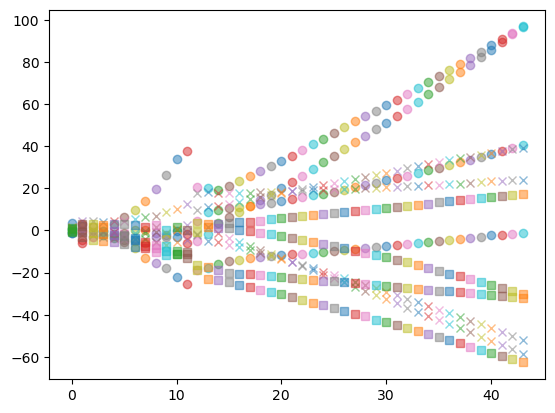

In [19]:
f=plt.figure()


for epoch in range(44):
    model = getattr(sys.modules[__name__], configs['model_type'])(exp.configs, \
        exp.a, exp.pert_begin, exp.pert_end, noise=True)
    # model = TwoHemiRNNTanh_single_readout(configs, exp.a, exp.pert_begin, exp.pert_end)
    exp.init_sub_path(exp.configs['train_type'])

    checkpoint_file = f'model_epoch_{epoch}.pth'
    # checkpoint_file = 'model_epoch_18.pth'
    checkpoint_path = os.path.join(exp.configs['models_dir'], exp.configs['model_type'], exp.sub_path, checkpoint_file)
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")
    # print(checkpoint_path)
    state_dict = torch.load(checkpoint_path, map_location='cpu', weights_only=True)
    model.load_state_dict(state_dict)

    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # CW Mac update
    model = model.to(device)
    model.eval()

    model.rnn_cell.w_hh_linear_rl.weight.data.cpu().numpy()
    readout_weights = model.readout_linear.weight.data.cpu().numpy()
    left_recurrent_weights = model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy()
    right_recurrent_weights = model.rnn_cell.w_hh_linear_rr.weight.data.cpu().numpy()

    plt.plot(np.ones(4) * epoch, readout_weights.flatten(), 'o', alpha=0.5)
    plt.plot(np.ones(4) * epoch, left_recurrent_weights.flatten(), 'x', alpha=0.5)
    plt.plot(np.ones(4) * epoch, right_recurrent_weights.flatten(), 's', alpha=0.5)


    

## Look at readouts given inputs

In [13]:
train_save_path = os.path.join(exp.configs['data_dir'], 'train')

train_sensory_inputs = np.load(os.path.join(train_save_path, 'onehot_sensory_inputs_simple.npy' ))
train_trial_type_labels = np.load(os.path.join(train_save_path, 'onehot_trial_type_labels_simple.npy'))
# load train inputs and labels

train_sensory_inputs.shape, train_trial_type_labels.shape

l_trial_idx = np.where(train_trial_type_labels == 0)[0]
r_trial_idx = np.where(train_trial_type_labels == 1)[0]

l_trial_input = train_sensory_inputs[l_trial_idx, :]
r_trial_input = train_sensory_inputs[r_trial_idx, :]

l_trial_input = torch.tensor(l_trial_input).to(device)
r_trial_input = torch.tensor(r_trial_input).to(device)
l_trial_input.shape

sample_begin = exp.sample_begin
delay_begin = exp.delay_begin
bias = model.readout_linear.bias.data.cpu().numpy()[0]
readout_weights = model.readout_linear.weight.data.cpu().numpy()
recurrent_weights = model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy()
input_weights = model.w_xh_linear_left_alm.weight.data.cpu().numpy()
recurrent_bias = model.rnn_cell.w_hh_linear_ll.bias.data.cpu().numpy()


torch.Size([500, 125, 2])


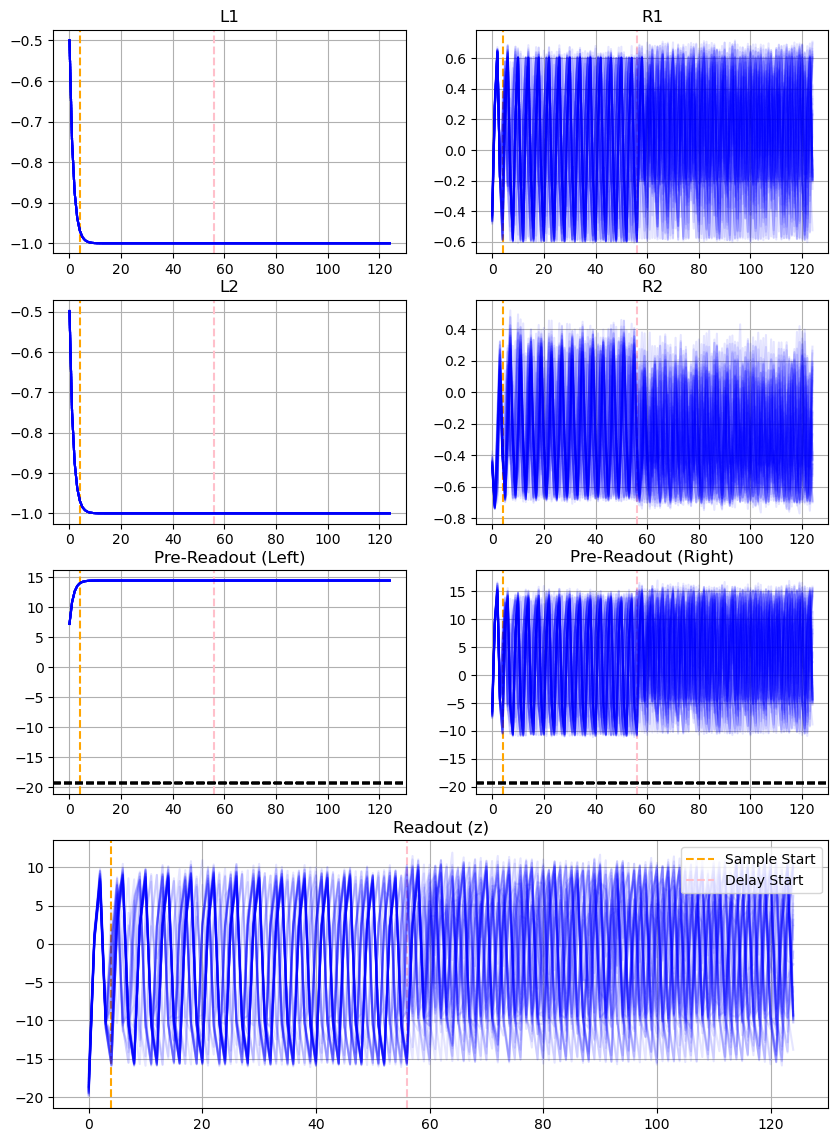

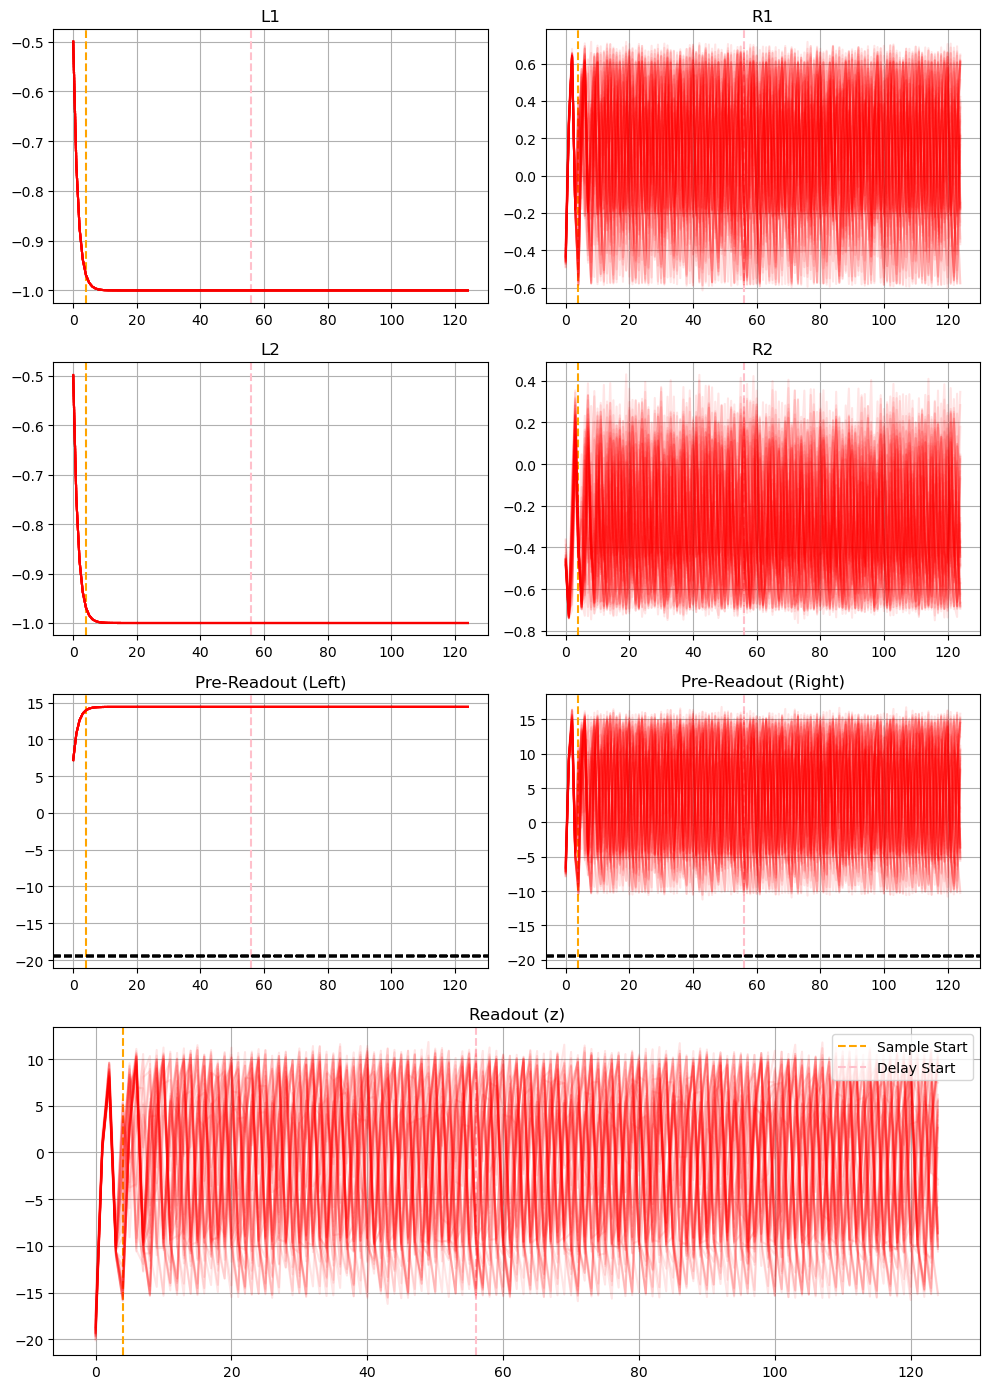

<Figure size 640x480 with 0 Axes>

In [14]:
# plot as overlay over all trials


import matplotlib.gridspec as gridspec
l_trial_input_all, r_trial_input_all = l_trial_input, r_trial_input

# Overlay all 500 trials for left and right trials individually onto the same set of subplots
# l_trial_input_all, r_trial_input_all = l_trial_input, r_trial_input

# Prepare figure and axes for left trials
fig_left = plt.figure(figsize=(10, 14))
gs_left = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 1.2])
titles = ['L1', 'L2', 'R1', 'R2']
axs_left = []

# Arrange L1 and L2 in the left column (col=0), R1 and R2 in the right column (col=1)
# L1: row 0, col 0; L2: row 1, col 0; R1: row 0, col 1; R2: row 1, col 1
subplot_positions = [(0, 0), (1, 0), (0, 1), (1, 1)]
for i, (row, col) in enumerate(subplot_positions):
    ax = fig_left.add_subplot(gs_left[row, col])
    ax.set_title(titles[i])
    ax.grid(True)
    # Add vertical lines for sample_begin and delay_begin
    ax.axvline(sample_begin, color='orange', linestyle='--', label='Sample Start' if i == 0 else None)
    ax.axvline(delay_begin, color='pink', linestyle='--', label='Delay Start' if i == 0 else None)
    axs_left.append(ax)

# Add pre-readout axes for left and right (row 2, col 0 and col 1)
ax_pre_left = fig_left.add_subplot(gs_left[2, 0])
ax_pre_left.set_title('Pre-Readout (Left)')
ax_pre_left.grid(True)
ax_pre_left.axvline(sample_begin, color='orange', linestyle='--', label='Sample Start')
ax_pre_left.axvline(delay_begin, color='pink', linestyle='--', label='Delay Start')

ax_pre_right = fig_left.add_subplot(gs_left[2, 1])
ax_pre_right.set_title('Pre-Readout (Right)')
ax_pre_right.grid(True)
ax_pre_right.axvline(sample_begin, color='orange', linestyle='--', label='Sample Start')
ax_pre_right.axvline(delay_begin, color='pink', linestyle='--', label='Delay Start')

# Readout axis (last row)
ax_zs_left = fig_left.add_subplot(gs_left[3, :])
ax_zs_left.set_title('Readout (z)')
ax_zs_left.grid(True)
ax_zs_left.axvline(sample_begin, color='orange', linestyle='--', label='Sample Start')
ax_zs_left.axvline(delay_begin, color='pink', linestyle='--', label='Delay Start')

# Prepare figure and axes for right trials
fig_right = plt.figure(figsize=(10, 14))
gs_right = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 1.2])
axs_right = []
for i, (row, col) in enumerate(subplot_positions):
    ax = fig_right.add_subplot(gs_right[row, col])
    ax.set_title(titles[i])
    ax.grid(True)
    # Add vertical lines for sample_begin and delay_begin
    ax.axvline(sample_begin, color='orange', linestyle='--', label='Sample Start' if i == 0 else None)
    ax.axvline(delay_begin, color='pink', linestyle='--', label='Delay Start' if i == 0 else None)
    axs_right.append(ax)

# Add pre-readout axes for left and right (row 2, col 0 and col 1)
ax_pre_left_r = fig_right.add_subplot(gs_right[2, 0])
ax_pre_left_r.set_title('Pre-Readout (Left)')
ax_pre_left_r.grid(True)
ax_pre_left_r.axvline(sample_begin, color='orange', linestyle='--', label='Sample Start')
ax_pre_left_r.axvline(delay_begin, color='pink', linestyle='--', label='Delay Start')

ax_pre_right_r = fig_right.add_subplot(gs_right[2, 1])
ax_pre_right_r.set_title('Pre-Readout (Right)')
ax_pre_right_r.grid(True)
ax_pre_right_r.axvline(sample_begin, color='orange', linestyle='--', label='Sample Start')
ax_pre_right_r.axvline(delay_begin, color='pink', linestyle='--', label='Delay Start')

# Readout axis (last row)
ax_zs_right = fig_right.add_subplot(gs_right[3, :])
ax_zs_right.set_title('Readout (z)')
ax_zs_right.grid(True)
ax_zs_right.axvline(sample_begin, color='orange', linestyle='--', label='Sample Start')
ax_zs_right.axvline(delay_begin, color='pink', linestyle='--', label='Delay Start')

print(l_trial_input_all.shape)
# Overlay all 500 trials

hs, zs = model(l_trial_input_all)
hs_r, zs_r = model(r_trial_input_all)

# Pre-readout: for left trials, left = hs[...,0], right = hs[...,1]
# For right trials, left = hs_r[...,0], right = hs_r[...,1]
for trial_idx in range(50):

    # Plot left trial
    for i in range(4):
        axs_left[i].plot(hs[trial_idx, :, i].detach().cpu().numpy(), color='red', alpha=0.1)

        # (hs.detach().cpu().numpy()[0] * readout_weights.flatten()).shape

    pre_left_readout = np.sum(hs[trial_idx, :, :2].detach().cpu().numpy() * readout_weights.flatten()[:2], axis=1)
    pre_right_readout = np.sum(hs[trial_idx, :, 2:].detach().cpu().numpy() * readout_weights.flatten()[2:], axis=1)
    ax_pre_left.plot(pre_left_readout, color='red', alpha=0.1)
    ax_pre_right.plot(pre_right_readout, color='red', alpha=0.1)
    ax_pre_left.axhline(bias, color='black', alpha=0.5, ls='--')
    ax_pre_right.axhline(bias, color='black', alpha=0.5, ls='--')
    ax_zs_left.plot(zs[trial_idx, :, 0].detach().cpu().numpy(), color='red', alpha=0.1)

    # Plot right trial
    for i in range(4):
        axs_right[i].plot(hs_r[trial_idx, :, i].detach().cpu().numpy(), color='blue', alpha=0.1)

    pre_left_readout = np.sum(hs_r[trial_idx, :, :2].detach().cpu().numpy() * readout_weights.flatten()[:2], axis=1)
    pre_right_readout = np.sum(hs_r[trial_idx, :, 2:].detach().cpu().numpy() * readout_weights.flatten()[2:], axis=1)
    ax_pre_left_r.plot(pre_left_readout, color='blue', alpha=0.1)
    ax_pre_right_r.plot(pre_right_readout, color='blue', alpha=0.1)
    ax_pre_left_r.axhline(bias, color='black', alpha=0.5, ls='--')
    ax_pre_right_r.axhline(bias, color='black', alpha=0.5, ls='--')
    ax_zs_right.plot(zs_r[trial_idx, :, 0].detach().cpu().numpy(), color='blue', alpha=0.1)

# Add legends only to the last subplot to avoid clutter
ax_zs_left.legend(loc='upper right')
ax_zs_right.legend(loc='upper right')

plt.figure(fig_left.number)
plt.tight_layout()
plt.show()

plt.figure(fig_right.number)
plt.tight_layout()
plt.show()